In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

sns.set_style("whitegrid")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# actMath_11_df

## Data exploration

In [3]:
actMath_11_df = pd.read_csv('dataframes/actMath_11.csv')

In [4]:
# Shape should be (3837, 242)
print(actMath_11_df.shape)
actMath_11_df.head()

(3837, 242)


,studentId,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,cours

In [5]:
# Check for class imbalance
actMath_11_df['is_proficient'].value_counts()

is_proficient
False    2234
True     1603
Name: count, dtype: int64

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_53983/78070154.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)


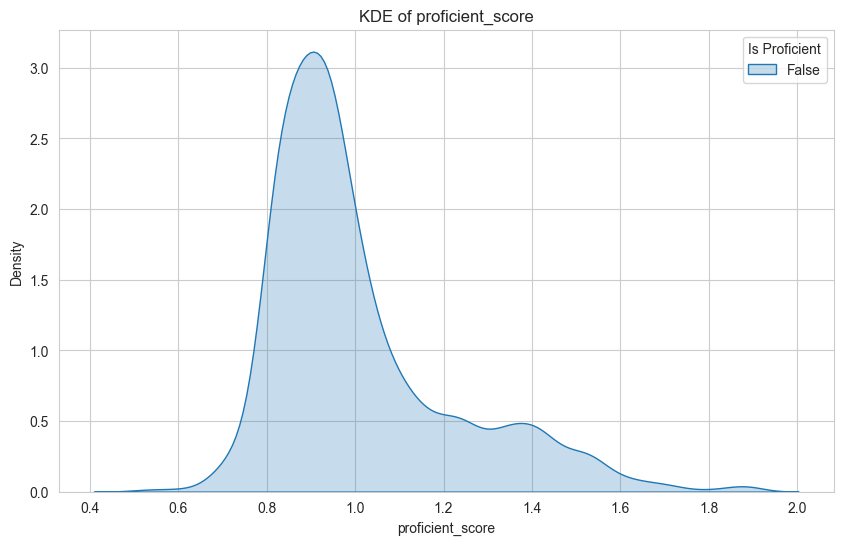

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)
plt.title('KDE of proficient_score')
plt.xlabel('proficient_score')
plt.ylabel('Density')
plt.legend(title='Is Proficient', labels=['False', 'True'])
plt.show()

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_53983/639794907.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=actMath_11_df, x='proficient_diff', shade=True)


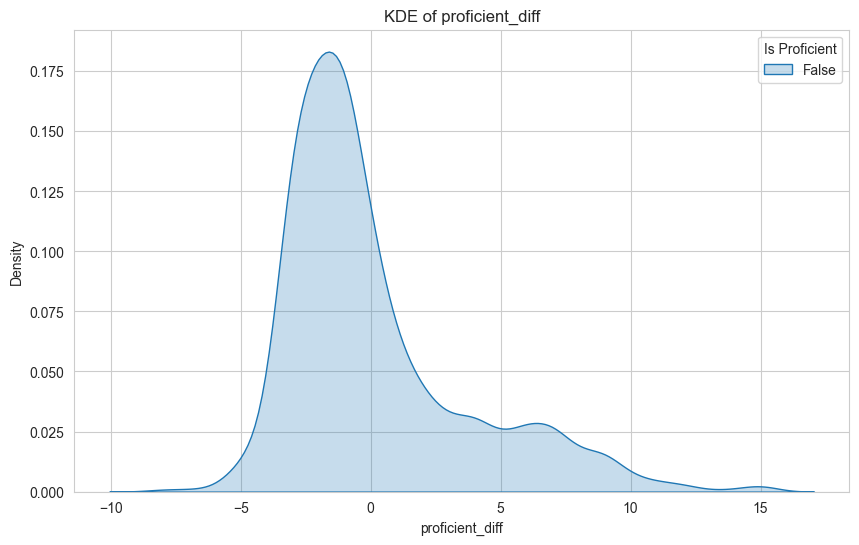

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=actMath_11_df, x='proficient_diff', shade=True)
plt.title('KDE of proficient_diff')
plt.xlabel('proficient_diff')
plt.ylabel('Density')
plt.legend(title='Is Proficient', labels=['False', 'True'])
plt.show()

In [8]:
actMath_11_df.head()

,studentId,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,cours

In [9]:
# Count the number of students enrolled in each course
course_columns = [col for col in actMath_11_df.columns if col.startswith('course_')]
course_enrollment = actMath_11_df[course_columns].sum().sort_values(ascending=False)

# Print the number of students enrolled in each course, sorted by most popular
print("Number of students enrolled in each course:")
for course, count in course_enrollment.items():
    if count > 0:
        print(f"{course}: {count}")

Number of students enrolled in each course:
course_Physical Sci: 1776
course_English Gr10: 1721
course_D&TSafetyEd: 1450
course_Health 9-12: 1394
course_Algebra I B: 1229
course_USHis I G10: 1199
course_Mustang Advi: 994
course_Eng Gr10 Adv: 927
course_ChemistryAdv: 735
course_USHis I Adv: 704
course_Geometry: 659
course_HEALTH 9-12: 647
course_DRIVERS ED: 609
course_US His-1877: 483
course_CareerPrep-B: 472
course_Panther Adv: 442
course_Alg II/Trig: 406
course_BullBogAdv: 340
course_LIFE PE 9-12: 308
course_Spanish 1: 283
course_FACS: 247
course_VarFBII: 208
course_Fund Agrisci: 186
course_Theatre I: 178
course_ALIITRIGH/A: 176
course_HS US 10 ADV: 172
course_Spanish 2: 171
course_ARMY LET II: 169
course_StudyHall912: 166
course_VisArtI.5C: 165
course_Fit/Cond: 147
course_Phy Sci Adv: 145
course_Intermed Agr: 129
course_Geometry Adv: 127
course_BandMarch.5C: 120
course_Agriscience: 110
course_LIFEPE9-12.5: 107
course_BANDCONCERT: 100
course_Int Metl Fab: 100
course_BAND MARCH: 100
co

In [10]:
course_enrollment_top50 = course_enrollment.head(50)

Use only the 50 most enrolled features.

In [11]:
actMath_11_top50_df = actMath_11_df.drop(columns=[col for col in actMath_11_df.columns if col.startswith('course_') and col not in course_enrollment_top50.index])

In [12]:
actMath_11_top50_df.head()

,studentId,is_proficient,proficient_score,proficient_diff,course_ALIITRIGH/A,course_ARMY LET II,course_Agriscience,course_Alg II/Trig,course_Algebra I B,course_BAND MARCH,course_BANDCONCERT,course_BandMarch.5C,course_BullBogAdv,course_CareerPrep-B,course_ChemistryAdv,course_ContempIss1C,course_D&TSafetyEd,course_DRIVERS ED,course_Eng Gr10 Adv,course_English Gr10,course_FACS,course_Fit/Cond,course_Food Nutritn,course_Fund Agrisci,course_GEOM ADV,course_Geometry,course_Geometry Adv,course_HEALTH 9-12,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_Hosp Tourism,course_IT Fndamntls,course_Int Metl Fab,course_Intermed Agr,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_Mnt Lt Rpr A,course_Music App,course_Mustang Advi,course_Panther Adv,course_Phy Sci Adv,course_Physical Sci,course_Psychology,course_Spanish 1,course_Spanish 2,course_StudyHall912,course_Theatre I,course_US His-1877,course_USHis I Adv,course_USHis I G10,course_VarFBII,course_Vis Arts I,course_VisArtI.5C,school_High School A,school_High School B,school_High School C,school_High School D,iready_math,iready_reading,bbb_literacy
0,45054,False,0.529412,-8.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0
1,45054,False,0.529412,-8.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,0,0
2,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0
3,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0
4,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0


Top 10 positive correlations with is_proficient:
course_ChemistryAdv    0.455131
course_Eng Gr10 Adv    0.432974
course_USHis I Adv     0.380754
course_Alg II/Trig     0.361428
course_ALIITRIGH/A     0.208321
course_HISTUS1877AC    0.155277
course_HS US 10 ADV    0.133161
course_Phy Sci Adv     0.128647
Name: is_proficient, dtype: float64

Top 10 negative correlations with is_proficient:
course_Agriscience    -0.063192
course_StudyHall912   -0.081430
course_LIFE PE 9-12   -0.100498
studentId             -0.120698
course_US His-1877    -0.128694
course_USHis I G10    -0.184592
course_English Gr10   -0.226305
course_Physical Sci   -0.261735
course_Algebra I B    -0.284771
bbb_literacy                NaN
Name: is_proficient, dtype: float64


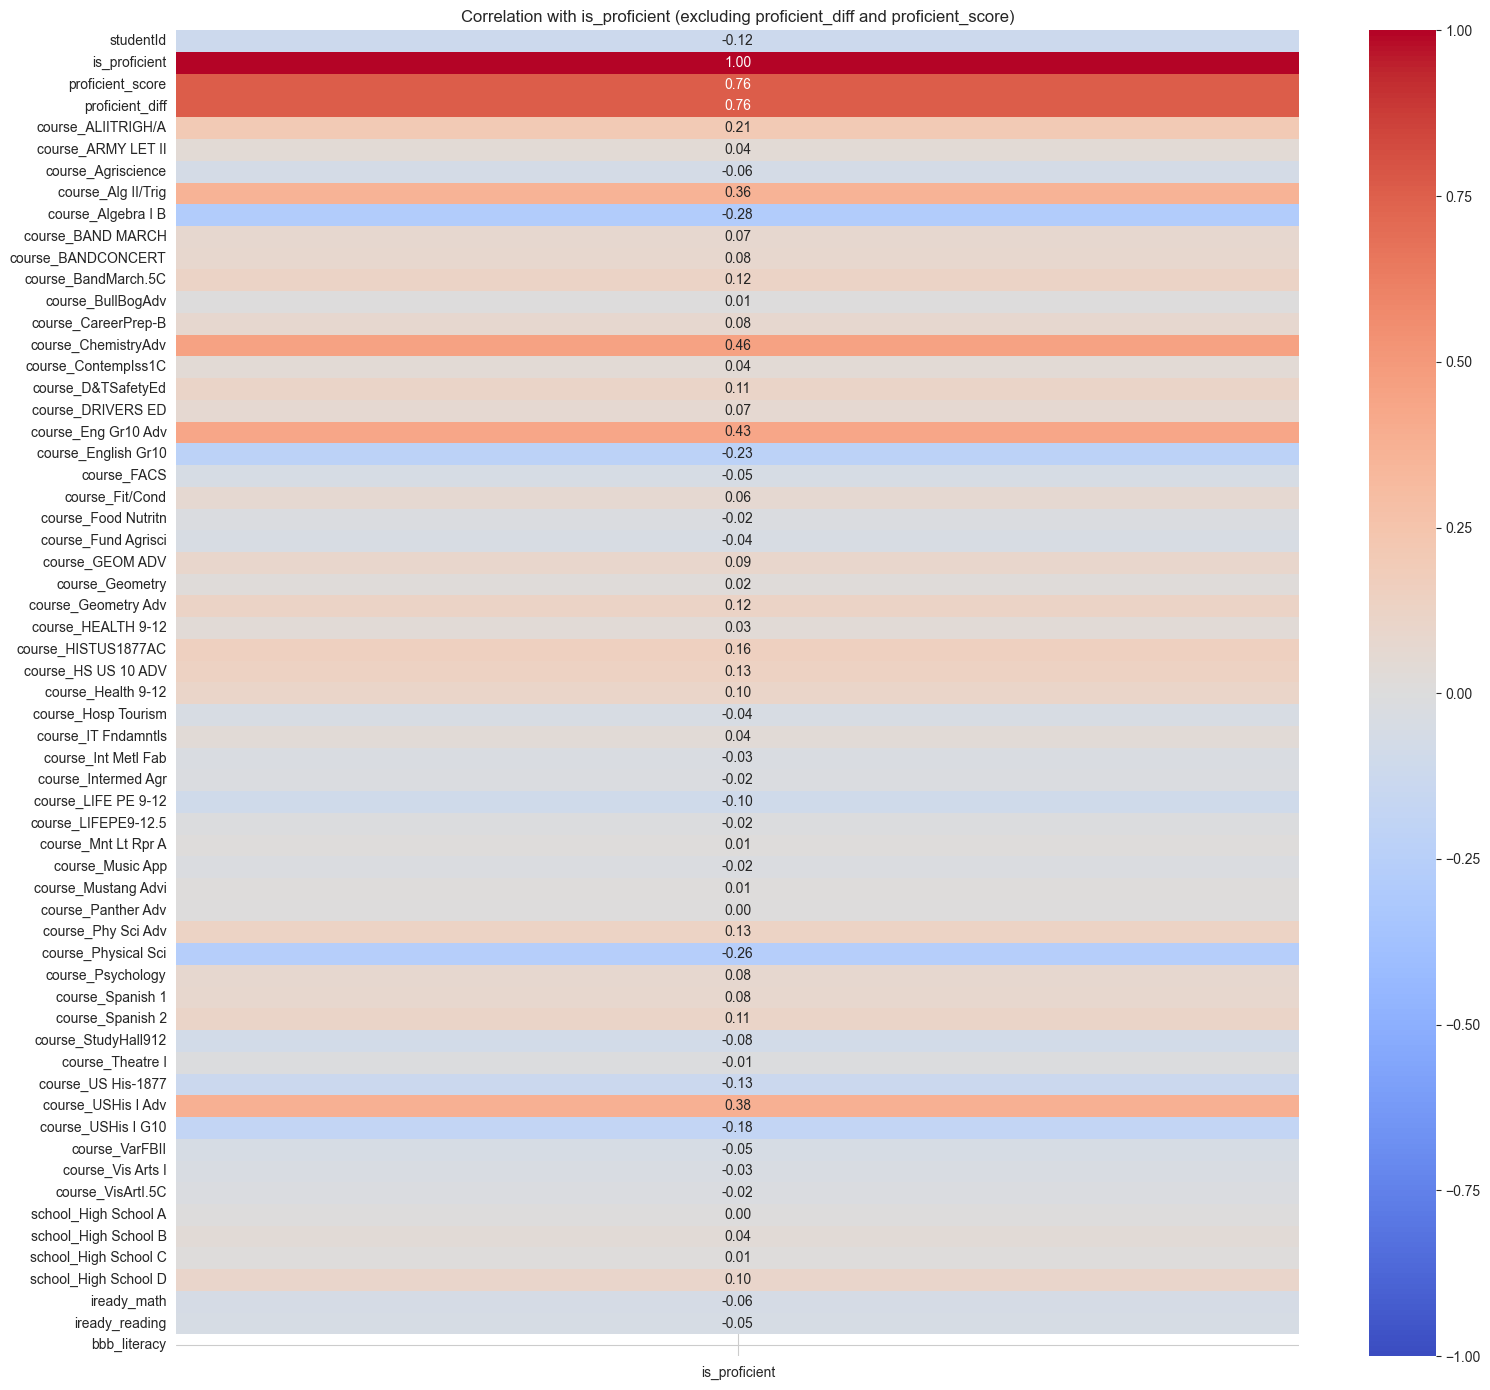

In [13]:
correlation_matrix = actMath_11_top50_df.corr()['is_proficient'].sort_values(ascending=False)

print("Top 10 positive correlations with is_proficient:")
print(correlation_matrix[3:11])  
print("\nTop 10 negative correlations with is_proficient:")
print(correlation_matrix[-10:])

plt.figure(figsize=(16, 14)) 
sns.heatmap(actMath_11_top50_df.corr()[['is_proficient']], 
            cmap='coolwarm', 
            annot=True, 
            cbar=True, 
            fmt='.2f',
            vmin=-1, 
            vmax=1,
            yticklabels=True)  
plt.title('Correlation with is_proficient (excluding proficient_diff and proficient_score)')
plt.tight_layout()
plt.show()


## Train models

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Logistic regression with top50 courses, binary label

In [15]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score', 'proficient_diff'], axis=1)
y = actMath_11_top50_df['is_proficient']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a logistic regression model
model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=123)
model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Function to evaluate model at different thresholds
def evaluate_model(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nClassification Report (Threshold = {threshold}):")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Evaluate model at different thresholds
threshold = 0.5
evaluate_model(y_test, y_pred_proba, threshold)

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

       False       0.75      0.92      0.83       447
        True       0.84      0.57      0.68       321

    accuracy                           0.78       768
   macro avg       0.80      0.75      0.75       768
weighted avg       0.79      0.78      0.77       768


Confusion Matrix:
[[412  35]
 [137 184]]

Top 10 Most Important Features:
                feature  importance
37   course_Phy Sci Adv    1.643129
3    course_Alg II/Trig    1.623122
4    course_Algebra I B    1.169097
24  course_HISTUS1877AC    1.098383
10  course_ChemistryAdv    1.042876
49    course_VisArtI.5C    0.996649
16          course_FACS    0.980959
54          iready_math    0.926780
8     course_BullBogAdv    0.926126
39    course_Psychology    0.900633


### Linear regression with top50 courses, continuous label

In [16]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score', 'proficient_diff'], axis=1)
y = actMath_11_top50_df['proficient_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_continuous = model.predict(X_test)

# Should predict >1.0 if proficient, <1.0 if not proficient
threshold = 1.2  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

threshold= 1.2

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.93      0.92       644
        True       0.58      0.52      0.55       124

    accuracy                           0.86       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.86      0.86      0.86       768


Confusion Matrix:
[[596  48]
 [ 59  65]]

Top 10 Most Important Features:
                 feature    importance
52  school_High School C  3.680206e+11
35   course_Mustang Advi  3.680206e+11
50  school_High School A  2.904876e+09
36    course_Panther Adv  2.904876e+09
3     course_Alg II/Trig  1.544326e-01
0     course_ALIITRIGH/A  1.377678e-01
10   course_ChemistryAdv  1.067122e-01
4     course_Algebra I B  9.784591e-02
37    course_Phy Sci Adv  9.598229e-02
51  school_High School B  8.515503e-02


False negative (someone who is not proficient but predicted to be proficient) is worse than false positive, so focus on recall. 

In [17]:
courses_by_subject = {
    "Math": [
        "course_Algebra I B", "course_Algebra I A", "course_Algebra I", "course_AlgebraicCon",
        "course_Alg II/Trig", "course_ALIITRIGH/A", "course_Alg Esntls B", "course_Algebra II",
        "course_Alg II/TrigAC", "course_Geometry", "course_Geometry Adv", "course_GeometryACCE",
        "course_GEOM ADV", "course_Alg I B ACCE", "course_AlgEnrichmet"
    ],
    "Science": [
        "course_Physical Sci", "course_Phy Sci Adv", "course_Biology", "course_Chemistry",
        "course_ChemistryAdv", "course_Biology Adv", "course_BIOLOGY ADV", "course_Anat/Physio", 
        "course_Marine Sci", "course_Ear/SpaceSci", "course_Enviro Sci", "course_For/Cri Inve", 
        "course_Forestry", "course_Intermed Agr", "course_Agriscience", "course_Advanced Agr", 
        "course_Fund Agrisci"
    ],
    "English": [
        "course_English Gr10", "course_Eng Gr10 Adv", "course_English Gr11", "course_EngLang,BS10", 
        "course_Eng Ess 10", "course_Eng Ess 11", "course_Eng Ess 11", "course_EngGr9-CR", 
        "course_EngEss: Phy Sci", "course_Ess: Phy Sci", "course_English Gr 9", "course_EnglGr10ACCE"
    ],
    "History": [
        "course_USHis I G10", "course_USHis I Adv", "course_US His-1877", "course_HISTUS1877AC", 
        "course_USHis InD-P", "course_HS US 10 ADV", "course_Enviro Sci", "course_USHisIG10ACC", 
        "course_USHis 1877-P", "course_WH 1500-P", "course_WH 1500-P Adv", "course_WH1500-P-CR"
    ],
    "Foreign Language": [
        "course_Spanish 1", "course_Spanish 2", "course_Spanish 3", "course_SPANISH I", 
        "course_SPANISH II", "course_SpanIACC", "course_SPAN II ACCE", "course_FrenchIACCE", 
        "course_German1ACCES", "course_LATIN 1 ACC"
    ]
}